# netCDF creator for point data
This notebook will aid in the use of the netCDF4 package and to correctly format your data in accordance with CF metadata conventions (https://cfconventions.org/). This notebook is focused on point data (such as lat,lon,number) usually collected in transects or grids, with a special focus on data collected with UAV's. However, this notebook should be useful for any type of transect dataset.

Author: Rolf-Ole Rydeng Jenssen

In [1]:
# Imports

import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import netCDF4  # Note: python is case-sensitive!
import datetime
from netCDF4 import date2num, num2date
import time
import warnings
import os
import requests

warnings.filterwarnings("ignore")

# Define metadata global attributes --- Requires user input ---
Global attributes required to generate discovery metadata.
Edit these attributes according to the conventions. Go to https://adc.met.no/node/4 for explanations.


In [2]:
# For now it is set as separate variables to facilitate GUI input

# "Default values"
title = "Snow depth from UAV GPR"
conventions = "CF-1.6"
username = "Rolf"
source = "UWB radar"
featureType = "trajectory"
summary = (
    "Snow depth survey from drone-mounted UWB radar system."  # This can/should be long
)
license = "https://spdx.org/licenses/CC-BY-4.0.html(CC-BY-4.0)"  # Creative Commons Attribution 4.0 International
keywords = "GCMDSK:EARTH SCIENCE > SPECTRAL/ENGINEERING > RADAR > RADAR IMAGERY, GCMDSK:EARTH SCIENCE > CRYOSPHERE > SNOW/ICE > SNOW DEPTH"  # found at https://wiki.met.no/_media/polarprofile/products/metadatavocab/gcmd_science_keywords.pdf
keywords_vocabulary = "GCMDSK:GCMD Science Keywords"
data_assembly_center = "NORCE"
iso_topic_category = "climatologyMeteorologyAtmosphere"
creator_type = "Person"
creator_institution = "NORCE"
creator_name = "Rolf-Ole Rydeng Jenssen"
creator_email = "roje@norceresearch.no"
creator_url = "None"
institution = "NORCE Norwegian Research Centre"
project = "SIOS"
platform = "SIOS-Copernicus"
instrument = "Ultra Wideband Snow Sounder (UWiBaSS)"
# id = "something unique" # Datacenter host adds this
# publisher_email = " " # Datacenter host adds this
# publisher_url = " " # Datacenter host adds this
# publisher_name = "MET" # Datacenter host adds this
# naming_authority = "TBA" # Datacenter host adds this
# processing_level = "0-4" # Not important for all data https://www.earthdata.nasa.gov/engage/open-data-services-and-software/data-information-policy/data-levels


# These are attributes you might change between each dataset
notes = "Sawtooth survey. 5 m/s alt 8 m" # Example notes
station_name_local = "Fardalen" # Station name, or area name.


# Load the dataset --- Requires user input ---
This notebook is based around Python Classes and Objects.
In this example, the processed data is stored as a .pkl file, but it can be of any format as long as it is correctly assigned in the "Write data to variables" cell.
In test dataset can (in addition to the repo) be found at https://doi.org/10.5281/zenodo.7609866

Download test dataset from Zenodo if not already present

In [14]:
if not os.path.exists('tmp'):
    os.makedirs('tmp')
if not os.path.exists(os.path.join('tmp','2021_04_15_test.pkl')):
    file_url = 'https://zenodo.org/record/7609866/files/2021_04_15_test.pkl'
    r = requests.get(file_url, allow_redirects=True)
    with open(os.path.join('tmp','2021_04_15_test.pkl'), 'wb') as f:
        f.write(r.content)

In [4]:
# # Define class for dataset import. This is specific to the example dataset
# class rdr:
#     def __init__(self):
#         self.rxc = None

# Name of dataset you wish to import.
dataset_name = "2021_04_15_test"
file_ext = ".pkl"

# Directory where said file is
directory = "./tmp/"

with open(directory + dataset_name + file_ext, "rb") as inp:
    data = pickle.load(inp)

# Make output filename --- Requires user input ---
Decide what your .nc file should be called

In [5]:
output_name = 'netCDF_output'
# Or set it to the same as the dataset name
output_name = dataset_name


# Create NC file and add global attributes
Now we can create the .nc file and assign the previously defined attributes.

In [6]:

try:
    ncfile.close()  # just to be safe, make sure dataset is not already open.
    print("closed already open .nc file")
except:
    pass

# ncfile = netCDF4.Dataset("tmp/test.nc", mode="w", format="NETCDF4") # It might be useful to create a test.nc file in the beginning
# ncfile = netCDF4.Dataset("tmp/" + output_name + ".nc", mode="w", format="NETCDF4") # Assign dataset name to .nc file
ncfile = netCDF4.Dataset(directory + output_name + ".nc", mode="w", format="NETCDF4") # Put .nc file in the same directory as the dataset

# Generate datetime from timestamp
date_time = []
for i in data.timestamp:
    date_time.append(datetime.datetime.fromtimestamp(float(i)).isoformat())


# ACDD global attributes required to generate discovery metadata (extract from ACDD documentation)

# All of this should be string! Might be overkill to add str() here, but it might catch some mistakes when modding this code.

ncfile.title = str(title)
ncfile.Conventions = str(conventions)
ncfile.featureType = str(featureType)
ncfile.summary = str(summary)
ncfile.license = str(license)
ncfile.keywords = str(keywords)
ncfile.keywords_vocabulary = str(keywords_vocabulary)
ncfile.data_assembly_center = str(data_assembly_center)
ncfile.iso_topic_category = str(iso_topic_category)
ncfile.geospatial_lat_min = str(np.min(data.lat))
ncfile.geospatial_lat_max = str(np.max(data.lat))
ncfile.geospatial_lon_min = str(np.min(data.lon))
ncfile.geospatial_lon_max = str(np.max(data.lon))
ncfile.time_coverage_start = str(date_time[0])
ncfile.time_coverage_end = str(date_time[-1])
ncfile.history = str(
    (
        "Date and time of creation: ["
        + str(datetime.datetime.now().isoformat())
        + "] User: ["
        + username
        + "] Notes: ["
        + notes
        + "]"
    )
)
ncfile.source = str(source)
date_created = str(datetime.datetime.now().isoformat())
ncfile.creator_type = str(creator_type)
ncfile.creator_institution = str(creator_institution)
ncfile.creator_name = str(creator_name)
ncfile.creator_email = str(creator_email)
ncfile.creator_url = str(creator_url)
ncfile.institution = str(institution)
ncfile.project = str(project)
ncfile.platform = str(platform)
ncfile.instrument = str(instrument)

# ncfile.id = id
# ncfile.publisher_email = str(publisher_email)
# ncfile.publisher_url = str(publisher_url)
# ncfile.publisher_name = str(publisher_name)
# ncfile.naming_authority = naming_authority
# ncfile.processing_level = processing_level


# Create dimensions

station_name_strlen_dim = ncfile.createDimension(
    "station_name_strlen", len(station_name_local)
)  # Station name
relTime_dim = ncfile.createDimension(
    "relTime", len(data.timestamp)
)  # relative time axis

# Optional dimension for radargrams
fasttime_dim = ncfile.createDimension(
    "fasttime", len(data.fasttime)
)  # relative time axis


print(ncfile.history)


Date and time of creation: [2023-02-10T22:59:39.310881] User: [Rolf] Notes: [Sawtooth survey. 5 m/s alt 8 m]


# Define variables with time dimension --- Requires user input ---

In this cell we define the variables we want to inclulde in the dataset. Try to only use float64 format on variables that actually need that precision.

Standard names: https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html

In [7]:
# Station name variable...
station_name = ncfile.createVariable("station_name", "S1", ("station_name_strlen",))
# station_name.units = 'none'
station_name.long_name = "Station name"
station_name.cf_role = "trajectory_id"

# UAV flightstates

latitude = ncfile.createVariable("latitude", np.float64, ("relTime",))
latitude.units = "degrees_north"
latitude.long_name = "latitude"
latitude.standard_name = "latitude"

longitude = ncfile.createVariable("longitude", np.float64, ("relTime",))
longitude.units = "degrees_east"
longitude.long_name = "longitude"
longitude.standard_name = "longitude"

altitude = ncfile.createVariable("altitude", np.float32, ("relTime",))
altitude.units = "m"
altitude.standard_name = "altitude"
altitude.positive = "down"  # This takes a value of ‘up’ or ‘down’, indicating whether more positive values are further away from earth center (up), or toward earth center.

altimeter_range = ncfile.createVariable("altimeter_range", np.float32, ("relTime",))
altimeter_range.units = "m"
altimeter_range.standard_name = "altimeter_range"
altimeter_range.positive = "down"  # This takes a value of ‘up’ or ‘down’, indicating whether more positive values are further away from earth center (up), or toward earth center.

platform_roll = ncfile.createVariable("platform_roll", np.float32, ("relTime",))
platform_roll.units = "degree"
platform_roll.standard_name = "platform_roll"

platform_pitch = ncfile.createVariable("platform_pitch", np.float32, ("relTime",))
platform_pitch.units = "degree"
platform_pitch.standard_name = "platform_pitch"

platform_yaw = ncfile.createVariable("platform_yaw", np.float32, ("relTime",))
platform_yaw.units = "degree"
platform_yaw.standard_name = "platform_yaw"

relTime = ncfile.createVariable("relTime", np.float64, ("relTime",))
relTime.units = "seconds since 1970-01-01"
relTime.long_name = "Seconds since epoch"

# Radar data

air_snow = ncfile.createVariable("air_snow", np.float32, ("relTime",))
air_snow.units = "1"
air_snow.long_name = "Index indicating position of snow surface (snow-air interface). Can be offset relative to image"

snow_ground = ncfile.createVariable("snow_ground", np.float32, ("relTime",))
snow_ground.units = "1"
snow_ground.long_name = "Index indicating position of snow-ground interface. Can be offset relative to image"

snow_ground_rel = ncfile.createVariable("snow_ground_rel", np.float32, ("relTime",))
snow_ground_rel.units = "1"
snow_ground_rel.long_name = "Index indicating position of snow-ground interface relative to a flattened top surface. Can be offset relative to image"

depth = ncfile.createVariable(
    "depth", np.float64, ("relTime",)
)  # note: unlimited dimension is leftmost
depth.units = "m"  # snow depth # Converting to meters in the next cell [m]
depth.standard_name = "surface_snow_thickness"  # this is a CF standard name

bscan = ncfile.createVariable(
    "bscan", np.float32, ("fasttime", "relTime")
)  # note: unlimited dimension is leftmost
# bscan.units = 'cm' # snow depth
bscan.long_name = "Radar image B-scan. Pre-processed with fourier filtering and singular value decomposition (SVD)."  #
# print(depth)



# Write data to variables
Here we add our data to the previously defined variables. Make updates/changes here according to changes made in the previous cell

In [8]:
from sqlite3 import Timestamp
from netCDF4 import stringtochar

station_name._Encoding = 'ascii'
station_name[:] = stringtochar(np.array(station_name_local,dtype='S'+str(len(station_name_local))))


# Note: the "[:]" is necessary in these "write" statements

latitude[:] = data.lat
longitude[:] = data.lon
relTime[:] = data.timestamp

altitude[:] = data.alt
altimeter_range[:] = data.rngf/100 # Orgininally in [cm] from the dataset 
platform_roll[:] = data.roll
platform_pitch[:] = data.pitch
platform_yaw[:] = data.yaw
bscan[:,:] = data.rxsvd

air_snow[:] = data.top
snow_ground[:] = data.bottom
snow_ground_rel[:] = data.bottom_no_rec

# create a  array of snow depth
depth[:] = data.depth_snow/100  # Appends data along unlimited dimension, in [m]


# At this point we are done with the .nc file and can close it
ncfile.close()

# Visualize netCDF file and check for compliance
Check if everything looks good. Pay special attention to the number formatting. If float64 is not needed, consider reducing the precision.

In [9]:
import netCDF4
import matplotlib.pyplot as plt
from compliance_checker.runner import ComplianceChecker, CheckSuite

Check CF compliance

In [10]:
# Check CF compliance. The library seems to have issues locating the checkers.. Probably a simple fix to get this working. For now we need to do a call in the terminal
check_suite = CheckSuite()
check_suite.load_all_available_checkers()
# print(check_suite.checkers)
# Run cf checks
path = directory + output_name + ".nc"
checker_names = ['cf']
verbose = 0
criteria = 'normal'
output_filename = directory  + 'report.json'
output_format = 'json'
return_value, errors = ComplianceChecker.run_checker(path,checker_names,verbose,criteria)



--------------------------------------------------------------------------------
                         IOOS Compliance Checker Report                         
                                 Version 5.0.2                                  
                     Report generated 2023-02-10T22:59:40Z                      
                                     cf:1.8                                     
http://cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.html
--------------------------------------------------------------------------------
                               Corrective Actions                               
2021_04_15_test.nc has 2 potential issues


                                    Warnings                                    
--------------------------------------------------------------------------------
§2.3 Naming Conventions
* attribute station_name:_Encoding should begin with a letter and be composed of letters, digits, and underscores

§2

 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Snow depth from UAV GPR
    Conventions: CF-1.6
    featureType: trajectory
    summary: Snow depth survey from drone-mounted UWB radar system.
    license: https://spdx.org/licenses/CC-BY-4.0.html(CC-BY-4.0)
    keywords: GCMDSK:EARTH SCIENCE > SPECTRAL/ENGINEERING > RADAR > RADAR IMAGERY, GCMDSK:EARTH SCIENCE > CRYOSPHERE > SNOW/ICE > SNOW DEPTH
    keywords_vocabulary: GCMDSK:GCMD Science Keywords
    data_assembly_center: NORCE
    iso_topic_category: climatologyMeteorologyAtmosphere
    geospatial_lat_min: 78.1514
    geospatial_lat_max: 78.1534708
    geospatial_lon_min: 15.5047506
    geospatial_lon_max: 15.518507399999999
    time_coverage_start: 2021-04-15T09:49:14.631005
    time_coverage_end: 2021-04-15T09:52:06.869512
    history: Date and time of creation: [2023-02-10T22:59:39.310881] User: [Rolf] Notes: [Sawtooth survey. 5 m/s alt 8 m]
    source: UWB radar
    creator_type:

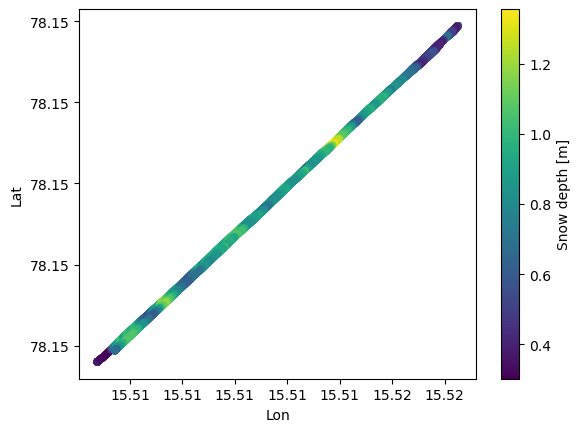

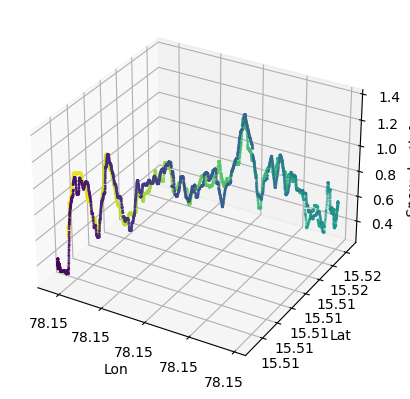

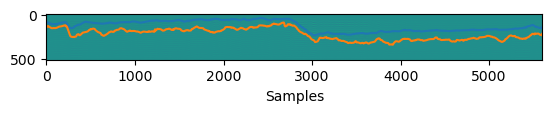

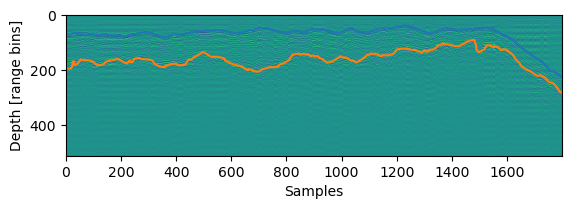

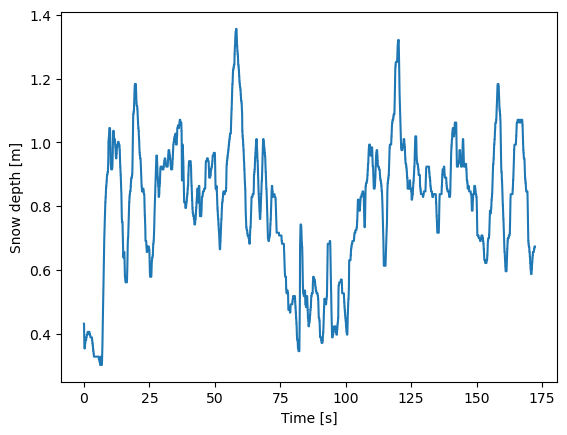

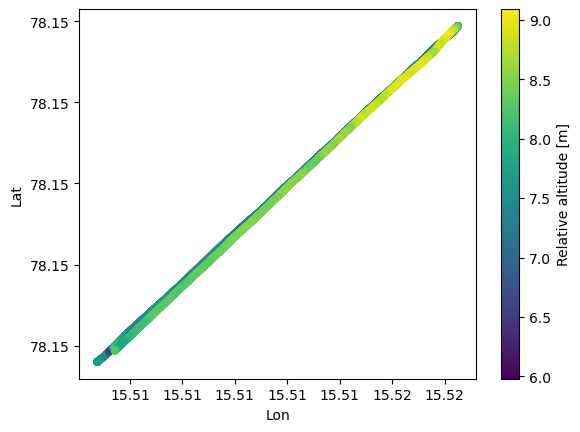

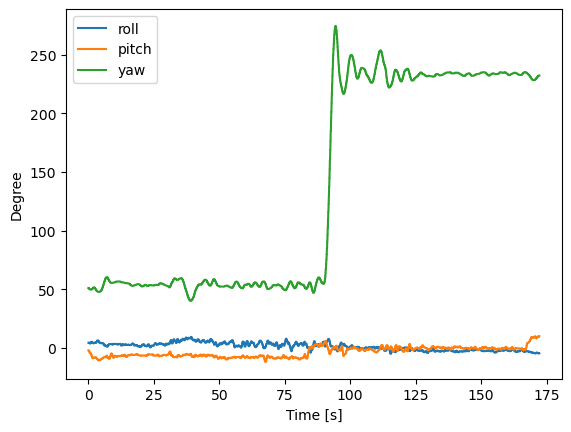

In [11]:
# Load the test file
# f = netCDF4.Dataset('tmp/test.nc', 'r')
# Or the file from the directory
f = netCDF4.Dataset(directory + output_name + ".nc", 'r')




# Print the metadata to terminal
print(' ')
print(f) 


# Extract the variables you wish to plot from the specified netCDF classes
depth = f.variables['depth'][:]  
lat = f.variables['latitude'][:]  
lon = f.variables['longitude'][:]
rel_alt = f.variables['altimeter_range'][:]
roll = f.variables['platform_roll'][:]  
pitch = f.variables['platform_pitch'][:]
yaw = f.variables['platform_yaw'][:]
time = f.variables['relTime'][:]
image = f.variables['bscan'][:,:]
top = f.variables['air_snow'][:]
bottom = f.variables['snow_ground_rel'][:]
station_name_load = f.variables['station_name'][:]

# # Might be useful for debugging to print all variable names
# for dname, d in f.variables.items():
#     print(d)

# plot as separate window
# %matplotlib qt

plt.figure()
plt.scatter(lon,lat,s=20,c=depth)
plt.colorbar(label = 'Snow depth [m]')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(lat, lon, depth,s=1, c=time-time[0])
# plt.scatter(lon,lat,s=20,c=depth)
# plt.colorbar(label = 'Snow depth [m]')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_zlabel('Snow depth [m]')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

# Show whole image
plt.figure()
plt.imshow(image)
plt.plot(top)
plt.plot(bottom)
plt.xlabel('Samples')
# plt.ylabel('Depth [range bins]')

# Show section of image
section = (1200,3000)
plt.figure()
plt.imshow(image[:,section[0]:section[1]])
plt.plot(top[section[0]:section[1]])
plt.plot(bottom[section[0]:section[1]])
plt.xlabel('Samples')
plt.ylabel('Depth [range bins]')


plt.figure()
plt.plot(time-time[0],depth)
plt.xlabel('Time [s]')
plt.ylabel('Snow depth [m]')

plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(lat, lon, rel_alt, c=rel_alt)
plt.scatter(lon,lat,s=20,c=rel_alt)
plt.colorbar(label = 'Relative altitude [m]')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

plt.figure()
plt.plot(time-time[0],roll,label = 'roll')
plt.plot(time-time[0],pitch,label = 'pitch')
plt.plot(time-time[0],yaw,label = 'yaw')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Degree')

plt.show()

# Conclusion

This notebook aims to gather information about CF conventions and other best practices when generating netCDF files. Many things can be improved regar

# Some additional utility that could be useful
-Find the name of a location given a coordinate

-Export data as .kml to plot in e.g., Google earth

In [12]:
# # Given lat lon, get name of area
# # import module
# from geopy.geocoders import Nominatim
# # initialize Nominatim API
# geolocator = Nominatim(user_agent="netCDF Generator")

# name_lat = str(data.lat[0])
# name_lon = str(data.lon[0])

# # Find location based on first coordinate in dataset 
# location = geolocator.reverse(name_lat+","+name_lon)
 
# # # Display
# print(location)

In [13]:
# # Export to .kml as well

# from __future__ import print_function
# from googleearthplot.googleearthplot import googleearthplot

# lon=data.lon#degree
# lat=data.lat#degree
# num = data.depth_snow
# size=1  #meter
# name="Snow depth"

# gep1=googleearthplot()

# gep1.PlotLineChart(lat, lon, heightList=num, name=name,color="aqua")

# gep1.GenerateKMLFile(filepath="tmp/test.kml")